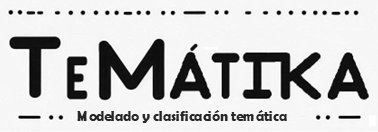

# Bienvenido a TeMátika

**TeMátika** es una herramienta diseñada para realizar modelado y clasificación temática de manera automatizada. Utilizando técnicas de minería de textos que permiten explorar y clasificar grandes volúmenes de texto, identificando los principales temas dentro de distintos documentos en **formato PDF**.

Para ello, recuerda que debes crear una carpeta en tu **Google Drive** personal llamada **data** y subir los archivos para el análisis, esta versión soporta sólo **formato PDF sin contraseña ni protecciones**. Es importante señalar que no extrae la información de imágenes, únicamente de la información en formato de texto.

Para iniciar puedes ejecutar el siguiente código para instalar las librerías necesarias

In [ ]:
!pip install tika
!pip install spacy
!pip install matplotlib
!pip install gensim
!pip install pyLDAvis
from tika import parser
import pandas as pd
import os
import csv
import spacy
import unicodedata
import re
from collections import Counter
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from google.colab import files
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Carga de información

En esta sección se cargará la información necesaria desde la carpeta **"data"** en Google Drive. Esta carpeta debe contener los archivos que se utilizarán para el modelado y clasificación temática, asegurándose de que estén en formato PDF sin contraseña ni protecciones. A partir de aquí, se extraerán y procesarán los datos para continuar con las etapas de preprocesamiento y modelado temático.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ruta_carpeta = '/content/drive/My Drive/data'
archivos_pdf = [f for f in os.listdir(ruta_carpeta) if f.endswith('.pdf')]
with open('data.csv', mode='w', newline='', encoding='utf-8') as datos:
    escritor = csv.writer(datos)
    escritor.writerow(['Nombre del archivo', 'Texto extraído'])
    for archivo_pdf in archivos_pdf:p
        ruta_pdf = os.path.join(ruta_carpeta, archivo_pdf)
        pdf_procesado = parser.from_file(ruta_pdf)
        texto = pdf_procesado['content']
        escritor.writerow([archivo_pdf, texto])
print("Archivos cargados y texto extraído exitosamente en 'data.csv'.")

### Preprocesamiento del texto

En esta sección, se lleva a cabo el preprocesamiento del texto extraído de los archivos PDF. Este proceso incluye varias etapas clave para limpiar y preparar el texto, primero se aplica un proceso de **normalización** del texto, el cual consiste en:
- Convertir el texto a **minúsculas** para eliminar la distinción entre mayúsculas y minúsculas.
- **Eliminar acentos** de las palabras utilizando la técnica de normalización de Unicode.
- **Eliminar caracteres especiales y números** que no aportan al análisis temático.
- **Eliminar letras individuales** que puedan generar ruido en el análisis.
- **Eliminar espacios en blanco adicionales**.

Una vez normalizado, se aplica la **lematización** utilizando la librería **Spacy**, que consiste en reducir las palabras a su forma base o raíz (por ejemplo, "corriendo" se convierte en "correr"). Además, durante este proceso, se eliminan las **stopwords** o palabras vacías (palabras comunes como "y", "de", "en", que no aportan al análisis) y los **signos de puntuación**.

In [ ]:
df = pd.read_csv('data.csv', encoding='utf-8')
def normalizar_texto(texto):
    texto = texto.lower()
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    texto = re.sub(r'[^a-z\s]', '', texto)
    texto = re.sub(r'\b\w\b', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto
df['Texto normalizado'] = df['Texto extraído'].apply(lambda x: normalizar_texto(str(x)))
!python -m spacy download es_core_news_sm
nlp = spacy.load('es_core_news_sm')
def preprocesar_texto(texto):
    doc = nlp(texto)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)
df['Texto lematizado'] = df['Texto normalizado'].apply(lambda x: preprocesar_texto(str(x)))
df.to_csv('data.csv', index=False, encoding='utf-8')
print("Preprocesamiento del texto completado y guardado en 'data.csv'.")

### Preparación de los datos

En esta sección, se procede a la última etapa de limpieza del texto antes de aplicar el modelado temático. Es importante eliminar aquellas palabras que pueden generar sesgos o ruido en los resultados. Esto puede incluir términos que, aunque sean frecuentes, no aportan valor al análisis específico que se quiere llevar a cabo.

Para facilitar esta tarea, se listan las 50 palabras que aparecen con mayor frecuencia en el corpus después de la lematización. Para ello, se deben revisar las palabras en la lista y escribirlas en la celda que se habilita, separadas por comas y sin espacios se la siguiente forma: **palabra1,palabra2,palabra3,....** y presiona Enter al incluir todas las que se desean eliminar

Si no deseas eliminar ninguna palabra, simplemente **presiona Enter** sin ingresar ningún término. En este caso, el texto no sufrirá cambios adicionales y el proceso continuará normalmente.

In [ ]:
texto_completo = ' '.join(df['Texto lematizado'])
palabras = texto_completo.split()
frecuencia_palabras = Counter(palabras)
palabras_mas_comunes = frecuencia_palabras.most_common(50)
print("Las 50 palabras más frecuentes:")
for palabra, frecuencia in palabras_mas_comunes:
    print(f"{palabra}: {frecuencia}")
palabras_a_eliminar = input("Introduce las palabras a eliminar, separadas por comas (o presiona Enter si no deseas eliminar ninguna): ").split(',')
if palabras_a_eliminar == ['']:
    palabras_a_eliminar = []  # Dejar la lista vacía si no se ingresan palabras
def eliminar_palabras_sesgo(texto, palabras_a_eliminar):
    return ' '.join([palabra for palabra in texto.split() if palabra not in palabras_a_eliminar])
df['Texto final'] = df['Texto lematizado'].apply(lambda x: eliminar_palabras_sesgo(x, palabras_a_eliminar))
df.to_csv('data.csv', index=False, encoding='utf-8')
print("Palabras eliminadas y texto actualizado en 'data.csv'.")

## Información global del corpus

En esta sección, se proporciona una visión general del texto final que será utilizado para el análisis temático.

- **Total de palabras en el corpus**: Este valor indica la cantidad total de palabras que componen el corpus.
- **Promedio de palabras por texto**: Representa la cantidad promedio de palabras que tiene cada documento.
- **Texto más largo**: El documento con la mayor cantidad de palabras.
- **Texto más corto**: El documento con el menor número de palabras podría indicar un documento anómalo.
- **Total de palabras únicas**: La cantidad de palabras que integran el corpus, donde las palabras se cuenta solo una vez, independientemente de cuántas veces aparezca en el texto.

Esta información ayuda a identificar patrones o irregularidades que pueden afectar los resultados del análisis temático y permite tomar acciones correctivas si se detectan documentos fuera de los parámetros normales.

In [ ]:
df['num_palabras'] = df['Texto final'].apply(lambda x: len(x.split()))
total_palabras = df['num_palabras'].sum()
promedio_palabras = df['num_palabras'].mean()
texto_mas_largo = df['num_palabras'].idxmax()
texto_mas_corto = df['num_palabras'].idxmin()
all_words = ' '.join(df['Texto final']).split()
palabras_unicas = len(set(all_words))
print(f"Información global del corpus:\n")
print(f"Total de palabras en el corpus: {total_palabras}")
print(f"Promedio de palabras por texto: {promedio_palabras:.2f}")
print(f"Texto más largo: {df['Nombre del archivo'][texto_mas_largo]} ({df['num_palabras'][texto_mas_largo]} palabras)")
print(f"Texto más corto: {df['Nombre del archivo'][texto_mas_corto]} ({df['num_palabras'][texto_mas_corto]} palabras)")
print(f"Total de palabras únicas en el corpus: {palabras_unicas}")

## Modelado temático basado en Asignación Latente de Dirichlet
En esta sección se implementa el **modelado temático** utilizando el algoritmo de **Asignación Latente de Dirichlet (LDA)** con Gensim. El objetivo es ayudar al usuario a seleccionar un número de temas que equilibre la coherencia del modelo y se ajuste a las necesidades del análisis para tener un análisis más eficiente.
   - Se genera una **gráfica de coherencia** que muestra la calidad de los resultados en función del número de temas. El usuario puede visualizar esta gráfica para seleccionar un número adecuado de temas. Se recomienda evitar elegir el número más alto o más bajo de coherencia eligiendo un número intermedio para evitar sobreajustes o falta de especificidad en los temas.
   - Una vez seleccionado el número de temas, el modelo se ejecuta y se genera la lista de las palabras más representativas por cada tema y descarga un archivo con la información.


In [ ]:
texts = [text.split() for text in df['Texto final']]
diccionario = corpora.Dictionary(texts)
corpus = [diccionario.doc2bow(text) for text in texts]
def calcular_valores_coherencia(diccionario, corpus, textos):
    valores_coherencia = []
    lista_modelos = []
    for num_temas in range(2, 10):
        modelo = gensim.models.LdaModel(corpus=corpus, num_topics=num_temas, id2word=diccionario, passes=10)
        lista_modelos.append(modelo)
        modelo_coherencia = CoherenceModel(model=modelo, texts=textos, dictionary=diccionario, coherence='c_v')
        valores_coherencia.append(modelo_coherencia.get_coherence())
    return lista_modelos, valores_coherencia
lista_modelos, valores_coherencia = calcular_valores_coherencia(diccionario, corpus, texts)
x = range(2, 10)
plt.plot(x, valores_coherencia)
plt.xlabel("Número de temas")
plt.ylabel("Coherencia")
plt.title("Gráfica de coherencia para elegir el número de temas")
plt.show()
num_temas = int(input("Ingresa el número de temas que deseas usar: "))
modelo_lda = gensim.models.LdaModel(corpus, num_topics=num_temas, id2word=diccionario, passes=10)
with open('palabras_por_tema.txt', mode='w', encoding='utf-8') as archivo:
    for indice, tema in modelo_lda.print_topics(-1):
        archivo.write(f"Tema {indice}:\n")
        archivo.write(f"{tema}\n")
        archivo.write("\n")
print("Las palabras clave por tema han sido guardadas como 'palabras_por_tema.txt'.")
files.download('palabras_por_tema.txt')


### Visualización interactiva con pyLDAvis

En esta sección, se genera una visualización interactiva que permite explorar los temas generados y sus relaciones con los documentos y palabras del corpus. **pyLDAvis** facilita la interpretación de los resultados del modelo LDA, mostrando gráficamente la proximidad entre los temas, así como las palabras más representativas de cada uno de ellos.

- El parámetro **lambda** en la visualización controla cómo se priorizan las palabras más frecuentes o las más exclusivas de cada tema:
   - **Lambda = 1**: Muestra las palabras más frecuentes en cada tema, destacando términos comunes que aparecen en varios temas.
   - **Lambda = 0**: Muestra las palabras más exclusivas de cada tema, es decir, aquellas que son distintivas y no tienen una influencia global en el corpus.

Se recomienda variar el valor de **lambda entre 0.5 y 1** para explorar tanto las palabras clave generales como las exclusivas de cada tema. Esto proporciona una comprensión más completa de los resultados del análisis temático, ya que permite equilibrar entre las palabras comunes y las exclusivas de cada tema.

Siéntete libre de interacturar con todos los elementos para comprender mejor los temas obtenidos y poder nombrarlos de la manera más adecuada.


In [ ]:
lda_visualizacion = gensimvis.prepare(modelo_lda, corpus, diccionario)
pyLDAvis.display(lda_visualizacion)

### Clasificación temática de los documentos
En esta sección, se asigna el **tema dominante** y los porcentajes de **pertenencia** de cada documento del corpus a cada uno de los temas generados por el modelo.

Se genera un archivo CSV que contiene el nombre de cada documento, el tema predominante y el porcentaje de pertenencia a todos los temas identificados. Esto permite analizar los documentos temáticamente y observar su relación con los distintos temas identificados.

In [ ]:
resultados = []
for i, fila in enumerate(corpus):
    temas = modelo_lda.get_document_topics(fila, minimum_probability=0)
    porcentajes = [round(probabilidad, 6) for _, probabilidad in temas]
    tema_predominante = max(temas, key=lambda x: x[1])[0]
    resultados.append([df['Nombre del archivo'][i], tema_predominante] + porcentajes)
columnas = ['Nombre del archivo', 'Tema predominante'] + [f'Tema {i}' for i in range(num_temas)]
df_resultados = pd.DataFrame(resultados, columns=columnas)
archivo_csv = 'resultados_lda.csv'
df_resultados.to_csv(archivo_csv, index=False, encoding='utf-8')
from google.colab import files
files.download(archivo_csv)
print("Archivo final descargado como 'resultados_lda.csv'.")

### ¡Gracias por usar TeMátika!

Esperamos que esta herramienta te haya sido útil para realizar el modelado y clasificación temática de tus documentos. TeMátika está diseñada para facilitar el análisis de grandes volúmenes de texto de manera accesible y eficiente.

Cualquier asunto relacionado con esta herramienta:
tematika@gmail.com